In [1]:
import os
import numpy as np
import pandas as pd

In [2]:
seed: int = 42

In [30]:
def read_csv(file: str) -> pd.DataFrame:
    df = pd.read_csv(os.path.join(os.getcwd(), f"dataset/{file}"))
    return df

In [31]:
titanic = read_csv("train_engineered.csv")
titanic_copy = titanic.copy()

In [32]:
titanic_copy.columns.values

array(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked', 'title', 'Age_present', 'Embarked_present'],
      dtype=object)

In [33]:
titanic_copy["Embarked"] = titanic_copy['Embarked'].replace(np.nan, "S")

In [35]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(titanic_copy, test_size=0.2, random_state=seed, stratify=titanic_copy["Survived"])

In [36]:
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder


numeric_features = ["Age", "Fare"]
ordinal_features = ["Pclass"]
categorical_features = ["Sex", "SibSp", "Parch", "Embarked", "title", "Embarked_present", "Age_present"]

numeric_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())])
categorical_transformer = OneHotEncoder(handle_unknown="error")
ordinal_transformer = OrdinalEncoder(handle_unknown="error")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
        ("ord", ordinal_transformer, ordinal_features),
    ]
)

In [37]:
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

from lightgbm import LGBMClassifier

classifiers = {
    "logit": Pipeline(steps=[("preprocessor", preprocessor), ("sampling", SMOTE()), ("classifier", LogisticRegression(random_state=seed))]),
    "rf": Pipeline(steps=[("preprocessor", preprocessor), ("sampling", SMOTE()), ("classifier", RandomForestClassifier(random_state=seed))]),
    "lbgm": Pipeline(steps=[("preprocessor", preprocessor), ("sampling", SMOTE()), ("classifier", LGBMClassifier(random_state=seed))]),
    "neural": Pipeline(steps=[("preprocessor", preprocessor), ("sampling", SMOTE()), ("classifier", MLPClassifier(random_state=seed))]),
    # "nb": Pipeline(steps=[("preprocessor", preprocessor), ("sampling", SMOTE()), ("classifier", GaussianNB())]),
    "ada": Pipeline(steps=[("preprocessor", preprocessor), ("sampling", SMOTE()), ("classifier", AdaBoostClassifier(random_state=seed))]),
}

In [38]:
y_train = train["Survived"]
del train["Survived"]

y_test = test["Survived"]
del test["Survived"]
    

In [39]:
import seaborn as sns    
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import KFold, cross_val_score

reports = []
kfold_results = []
names = []

for name, classifier in classifiers.items():
    names.append(name)
    
    # kfold
    kfold = KFold(n_splits=10, random_state=seed, shuffle=True)
    kfold_result = cross_val_score(classifier, train, y_train, cv=kfold, scoring='accuracy')
    kfold_results.append(kfold_result)
    
    # train test split
    classifier.fit(train, y_train)
    predictions = classifier.predict(test)
    reports.append({
        'name': name,
        'confusion': confusion_matrix(y_test, predictions),
        'accuracy': accuracy_score(y_test, predictions),
        'f1': f1_score(y_test, predictions)
    })

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\user\AppDa

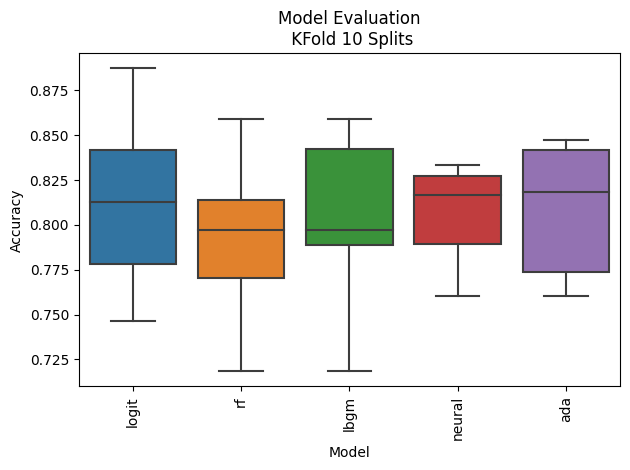

In [47]:

import seaborn as sns

g = sns.boxplot(data=kfold_results)
g.set_title('Model Evaluation\n KFold 10 Splits')
g.set_xlabel('Model')
g.set_ylabel('Accuracy')
g.set_xticklabels(names, rotation=90)
g.get_figure().tight_layout()

In [49]:
def print_model_stats(kfold_result, report):
    tn = report['confusion'][0][0] # True negative
    fp = report['confusion'][0][1] # False positive
    fn = report['confusion'][1][0] # False negative
    tp = report['confusion'][1][1] # True positive
    
    mr = 1 - report['accuracy'] # Misclassification rate
    tpr = tp / (fn + tp) # True positive rate
    fpr = fp / (tn + fp) # False positive rate
    spec = 1 - fpr # Specificity
    prec = tp / (fp + tp) # Precision    
    
    print('--------------------')
    print(report['name'])
    print('--------------------')
    print('F1 Score:        ', report['f1'])
    print('Accuracy:        ', report['accuracy'])
    print('Mean KFold (10): ', kfold_result.mean())
    print('Std. KFold (10): ', kfold_result.std())
    print('TPR:             ', tpr)
    print('FPR:             ', fpr)
    print('Specificity:     ', spec)
    print('Precision:       ', prec)
    print()
    
for kfold, report in zip(kfold_results, reports):
    print_model_stats(kfold_result, report)

--------------------
logit
--------------------
F1 Score:         0.7832167832167832
Accuracy:         0.8268156424581006
Mean KFold (10):  0.8092723004694836
Std. KFold (10):  0.03436048316145666
TPR:              0.8115942028985508
FPR:              0.16363636363636364
Specificity:      0.8363636363636364
Precision:        0.7567567567567568

--------------------
rf
--------------------
F1 Score:         0.7391304347826085
Accuracy:         0.7988826815642458
Mean KFold (10):  0.8092723004694836
Std. KFold (10):  0.03436048316145666
TPR:              0.7391304347826086
FPR:              0.16363636363636364
Specificity:      0.8363636363636364
Precision:        0.7391304347826086

--------------------
lbgm
--------------------
F1 Score:         0.7391304347826085
Accuracy:         0.7988826815642458
Mean KFold (10):  0.8092723004694836
Std. KFold (10):  0.03436048316145666
TPR:              0.7391304347826086
FPR:              0.16363636363636364
Specificity:      0.8363636363636364
P

In [62]:

import warnings
warnings.filterwarnings("ignore", message="Numerical issues were encountered ")

from sklearn.model_selection import GridSearchCV

hyperparameters = {
    "logit": {"param_grid": 
        {'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 
         'classifier__penalty': ["none", "l2", "l1"], 
         'classifier__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
        }},
    "rf": {"param_grid": {
        'classifier__max_features' : ["auto", "sqrt", "log2"],
        'classifier__min_samples_split' : np.linspace(0.1, 1.0, 10),
        'classifier__max_depth' : [x for x in range(1,20)]
    }},
    "ada": {"param_grid": {
        'classifier__learning_rate' : [0.0001, 0.001, 0.01, 0.1, 1.0],
        'classifier__n_estimators' : [10, 50, 100, 500]
    }},
    # "lgbm": {"param_grid": {
    #     ''
    # }}
    "neural": {"param_grid": {
        'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
        'activation': ['tanh', 'relu'],
        'solver': ['sgd', 'adam'],
        'alpha': [0.0001, 0.05],
        'learning_rate': ['constant','adaptive']
    }}
}

best_classifiers = {}

for key, params in hyperparameters.items():
    param_grid = params["param_grid"]
    model = classifiers[key]
    
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv= 10, n_jobs = -1, error_score=0.0)
    grid_search.fit(train, y_train)
    
    best_classifiers[key] = grid_search.best_estimator_
    
    print(key, grid_search.best_params_, grid_search.best_score_)

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
280 fits failed out of a total of 1050.
The score on these train-test partitions for these parameters will be set to 0.0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
70 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-pack

logit {'classifier__C': 1, 'classifier__penalty': 'none', 'classifier__solver': 'newton-cg'} 0.8149256651017215
rf {'classifier__max_depth': 13, 'classifier__max_features': 'sqrt', 'classifier__min_samples_split': 0.1} 0.8121087636932709
ada {'classifier__learning_rate': 1.0, 'classifier__n_estimators': 500} 0.8149647887323944
